## Importamos librerias

In [1]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, xgboost, operator, random, pickle

In [2]:
#pip install utils2

In [3]:
from utils2 import *

In [4]:
np.set_printoptions(threshold=50, edgeitems =20)

In [5]:
from isoweek import Week
from pandas_summary import DataFrameSummary

In [6]:
%cd C:/Users/Patricio/deep-learning/Machine-Learning/Laboratorio-Metodos de ensamble/dataset/rossmann/

C:\Users\Patricio\deep-learning\Machine-Learning\Laboratorio-Metodos de ensamble\dataset\rossmann


## Create datasets

In [7]:
def concat_csvs(dirname):
    os.chdir(dirname)
    filesnames = glob.glob("*.csv")
    
    wrote_header = False
    with open("../"+dirname+".csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                    outputfile.write(name + "," + line)
                outputfile.write("\n")
    os.chdir("..")

In [8]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']

In [9]:
tables = [pd.read_csv(fname+'.csv', low_memory = False) for fname in table_names]

In [10]:
from IPython.display import HTML

In [11]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [12]:
train, store, store_states, state_names, googletrend, weather, test = tables

## Limpieza y formateo de datos

In [13]:
#Convierto a booleanos
train.StateHoliday = train.StateHoliday != '0'
test.StateHoliday = test.StateHoliday != '0'

In [14]:
#Left join (Outer joins) por eso checkeamos si tiene nulos en la nueva tabla despues de correrlo
#Left join se queda con todas las filas de la primer tabla y mapea a los campos de la segunda tabla los que puede
def join_df(left, right, left_on, right_on = None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on = left_on, right_on = right_on, suffixes = ("", "_y"))

In [15]:
#Unimos tabla weather con state_names
weather = join_df(weather, state_names, "file", "StateName")

In [16]:
#Le asigna a la columna Date la primer fecha, la cual corresponde al comienzo de la semana
googletrend['Date'] = googletrend.week.str.split(' - ', expand = True)[0]
#Le asigna a la columna State la abreviacion del estado que escrita desoues del utimo _ en la columna 'file'
googletrend['State'] = googletrend.file.str.split('_', expand = True)[2]
#Cambia los valores NI de la columna State a HB,NI
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [17]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day

In [18]:
#Descomponemos la fecha en ano, mes, semana y dia y agregamos cada campo a la tabla
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

<ipython-input-17-07ed3435f455>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Week"] = df.Date.dt.week


In [19]:
#Guardamos todos los que tienen en file Rossmann_DE
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [20]:
#Al juntar las dos tablas agrega a la tabla Store el acronimo del estado 
store = join_df(store, store_states, "Store")
#Cantidad de filas en tabla Store con State vacio (checqueo por el outer join)
len(store[store.State.isnull()])

0

In [21]:
#Agrega a la tabla Train la informacion guardada en la tabla Store ya combinada (campos de Store + acronimo estado de cada tienda)
joined = join_df(train, store, "Store")
#Cantidad de filas en tabla Store con StoreType vacio
len(joined[joined.StoreType.isnull()])

0

In [23]:
#Agrega a la tabla anterior los campos de googletrend uniendolos segun la total coincidencia de los campos state, year, week
joined = join_df(joined, googletrend, ["State","Year", "Week"])
#Cantidad de filas en tabla resultante con trend vacio
len(joined[joined.trend.isnull()])

0

In [24]:
#Juntamos con los de Rossmann_DE
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
#Cantidad de filas en tabla resultante con trend vacio
len(joined[joined.trend_DE.isnull()])

0

In [25]:
#Juntamos con el clima en esa fecha en ese estado
joined = join_df(joined, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()])

0

In [26]:
#Juntamos los de test con los de store
#joined_test = test.merge(store, how='left', left_on = 'Store', right_index = True)
#Cantidad de filas en tabla resultante con StoreType vacio
#len(joined_test[joined_test.StoreType.isnull()])

In [27]:
#Llenamos los campos de joined vacios
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)
#Llenar con 1900 y 1 no es problema porue cada vez que falta un ano falta un mes entonces cualquier modelo va a aprovechar este agrupamiento para clasificarlo y trazar la regresion sin introducir datos falsos

In [28]:
#Agrega un campo fecha en la columna CompetitionOpenSince con ano=CompetitionOpensSinceYear, mes=CompetitionOpenSinceMonth, dia= 15 
joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))
#De la fecha del train le resta la de CompetitionOpenSince recien calculada y obtiene la cantidad de dias
#Hace cuantos dias abrio la competencia al dia que se efectuo la venta
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

In [29]:
#Si la competencia abrio despues de la venta (dias o anos < 0) lo reemplazamos por 0 
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [30]:
#Cantidad de meses (suponiendo 30 dias por mes) que la competencia lleva abierta (// es division entera) lo hago porque voy a usar embeddings con los meses (menos valores unicos)
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"]//30
#Si la competencia lleva mas de 24 meses limitarla a 24 para que no crezca tanto el embedding (valores unicos)
joined.loc[joined.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
#Cuales son los valores unicos
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5], dtype=int64)

In [31]:
#Idem anterior pero para Promo
#Asigna a Promo2Since la fecha del lunes de la semana Promo2SinceWeek en el ano Promo2SinceYear
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
#Cant de dias que transcurrieron desde la promocion
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

joined.loc[joined.Promo2Days<0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear<1990, "Promo2Days"] = 0

joined["Promo2Weeks"] = joined["Promo2Days"]//7
joined.loc[joined.Promo2Weeks<0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks>25, "Promo2Weeks"] = 25
joined.Promo2Weeks.unique()

array([ 0, 25, 17,  8, 13, 24, 16,  7, 12, 23, 15,  6, 11, 22, 14,  5, 10,
       21,  4,  9, 20,  3, 19,  2, 18,  1], dtype=int64)

In [32]:
#Idem para test
joined_test = join_df(test, store, "Store")
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = join_df(joined_test, weather, ["State","Date"])

joined_test.CompetitionOpenSinceYear = joined_test.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined_test.CompetitionOpenSinceMonth = joined_test.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined_test.Promo2SinceYear = joined_test.Promo2SinceYear.fillna(1900).astype(np.int32)
joined_test.Promo2SinceWeek = joined_test.Promo2SinceWeek.fillna(1).astype(np.int32)

joined_test["CompetitionOpenSince"] = pd.to_datetime(joined_test.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days

joined_test.loc[joined_test.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_test.loc[joined_test.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"]//30
joined_test.loc[joined_test.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24

joined_test["Promo2Since"] = pd.to_datetime(joined_test.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days

joined_test.loc[joined_test.Promo2Days<0, "Promo2Days"] = 0
joined_test.loc[joined_test.Promo2SinceYear<1990, "Promo2Days"] = 0

joined_test["Promo2Weeks"] = joined_test["Promo2Days"]//7
joined_test.loc[joined_test.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks>25, "Promo2Weeks"] = 25

## Duration

### Feature engineering

In [33]:
#Cada vez que hay una promocion o un feriado creo nuevos campos para esa venta de train como cuanto tiempo falta para las proximas vacaciones, las anteriores, promixa promocion, etc

In [34]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [35]:
#Funcion que lleva la cuenta cuando fue la ultima vez que vi un feature (ej: state_holiday)
class elapsed(object):
    #Inicializacion
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    #Como los datos estan ordenado segun Store y luego fecha va recorriendo en sentido ascendente (o descentente) todas las ventas, y calculando por venta hace cuanto fue la ultima vez que vio ese feature (o cuando sera la proxima)
    #al pasar a otro Store vuelve a inicializar
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [36]:
#Tabla con las columnas especificadas arriba
df = train[columns]

In [37]:
#Agrega a la tabla el nuevo feature (tiempo transcurrido desde ultima vez o hasta la proxima vez)
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [38]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
#La nueva columna se llamara 'nombre del campo'+'After'
add_elapsed(fld, 'After')
#Mismo pero en sentido inverso (hasta la proxima vez)
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [39]:
#Idem 2 campos mas
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [40]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [41]:
#Indexa por date (mas rapido)
df = df.set_index("Date")

In [42]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [43]:
#Rellena los valores nulos con 0s
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

In [44]:
#Calcula el numero de feriados o promociones que hay en una semana (suma para 7 dias anteriores) avanzando dia por dia por tienda y los vuelca en una tabla
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [ ]:
#El resultado de aplicar rolling a Store no tiene mucho sentido se lo utiliza para agrupar
bwd

In [45]:
#Lo mismo pero para la semana siguiente en vez de la anterior (suma 7 dias futuros)
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [46]:
#Borramos la columna Store

In [47]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [48]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [49]:
df.reset_index(inplace=True)

In [50]:
#Combinamos estas tablas con la de df que habiamos armado con las series de tiempo
#para juntarlas tienen que coincidir fecha y Store
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [51]:
#Eliminamos las columnas porque estan repetidas
df.drop(columns,1,inplace=True)

In [52]:
#Guardamos la tabla en un archivo csv
#df.to_csv('df.csv')

In [53]:
#Cargamos la tabla del archivo
#df = pd.read_csv('df.csv', index_col=0)

C:\Users\Patricio\anaconda3\envs\curso\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [54]:
df["Date"] = pd.to_datetime(df.Date)

In [55]:
joined = join_df(joined, df, ['Store', 'Date'])

In [56]:
#Guardamos la tabla en un archivo csv
joined.to_csv('joined.csv')

In [57]:
#Cargamos la tabla del archivo
joined = pd.read_csv('joined.csv', index_col=0)
joined["Date"] = pd.to_datetime(joined.Date)

In [58]:
#Idem test
def add_elapsed_to_test(fld, prefix):
    sh_el = elapsed(fld)
    df_test[prefix+fld] = df_test.apply(sh_el.get, axis=1)

columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
df_test = test[columns]

fld = 'SchoolHoliday'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed_to_test(fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed_to_test(fld, 'Before')

fld = 'StateHoliday'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed_to_test(fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed_to_test(fld, 'Before')

fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed_to_test(fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed_to_test(fld, 'Before')

df_test = df_test.set_index("Date")

columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days
        
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

bwd_test.drop('Store',1,inplace=True)
bwd_test.reset_index(inplace=True)

fwd_test.drop('Store',1,inplace=True)
fwd_test.reset_index(inplace=True)

df_test.reset_index(inplace=True)

df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

df_test.drop(columns,1,inplace=True)

df_test["Date"] = pd.to_datetime(df_test.Date)

joined_test = join_df(joined_test, df_test, ['Store', 'Date'])
joined_test["Date"] = pd.to_datetime(joined_test.Date)

## Creamos los features con los que vamos a entrar al modelo

In [59]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [60]:
#Defino la dimensionalidad de los embeddings para cada variable categorica
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [61]:
#Obtiene la key del diccionario ordenado segun los values en orden descendente y las guarda en cat_vars
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [62]:
cat_vars

['Store',
 'Day',
 'DayOfWeek',
 'Month',
 'State',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'Events',
 'StateHoliday',
 'Assortment',
 'PromoInterval',
 'Year',
 'CompetitionMonthsOpen',
 'StoreType',
 'Week',
 'Promo2Weeks',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_fw',
 'StateHoliday_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

In [63]:
#Lista de variables continuas
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [64]:
#Reemplaza los nulls en los campos de la tabla joined con 0s para las variables continuas y con espacios vacios para las categoricas
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

In [65]:
#Idem test
for v in contin_vars: joined_test.loc[joined_test[v].isnull(), v] = 0
for v in cat_vars: joined_test.loc[joined_test[v].isnull(), v] = ""

#### DataFrame mapper

In [66]:
#Tuplas donde el primer elemento es el nombre de la variable categorica y el segundo elemento es una instancia de la clase que hara el preprocesamiento para esa variable
#Labelencoder analiza los valores unicos de la variable y los reemplaza con un set de enteros contiguos(ej: lunes a domingo->0 a 7)
#El set de training y el de test tienen que tener la misma condificacion para las variables ej: domingo tiene que ser 6 en los dos. Por eso el objeto va a llevar la cuenta de que codificacion esta usando, lo guarda en el objeto 
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
#Normaliza las variables continuas
#Tambien se debe respetar la misma media y desvio estandard para el set de test, por eso se guarda en el objeto
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [67]:
#Contiene los features preprocesados, se le aplica la funcion de arriba (valores que se van a usar para embeddings)
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [68]:
#Mismo para las variables continuas
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

16

In [69]:
cat_map_fit.transform(joined)[0,:5], contin_map_fit.transform(joined)[0,:5]

(array([ 0, 30,  4,  6,  4]),
 array([-0.53772351,  1.02444552,  0.81863226,  0.32504749,  0.61112004]))

In [70]:
#Guarda los encodings y los parametro de scaling
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [71]:
#Muestra la cantidad de variables unicas para las variables categoricas
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

## Sample data

In [72]:
#Descarto las que no tienen ventas (esto no es recomendable)
joined_sales = joined[joined.Sales!=0]
#Cant de filas
n = len(joined_sales)

In [73]:
#Muestreo aleatorio
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [74]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [75]:
samp_size = n
joined_samp = joined_sales.set_index("Date")

In [76]:
#Porcentaje de train-validacion
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

In [77]:
#El test set en un timeseries va a tener los datos mas recientes
#Ya estan ordenados por fecha
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

In [78]:
#Efectua la operacion del dataFrame
#El cat_map_fir fue fitteado con los datos de train y validacion por lo tanto no habran valores extranos en validacion para las var cat
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [79]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

In [81]:
#Idem test
cat_map_test = cat_preproc(joined_test)

In [82]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [83]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

In [84]:
#Idem test
contin_map_test = contin_preproc(joined_test)

In [85]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

In [86]:
#Modificamos los targets (ventas) tal que:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y
#Los valores de y no superan 1, acorta la 'cola' es decir la distribucion de ventas no va a estar tan separada
#Permite usar una sigmoidea como funcion de activacion y multiplicarla por el max_log_y (pero en realidad esta tecnica no contribuye mucho)

In [87]:
#Implementamos la loss
def rmspe(y_pred, targ = y_valid_orig):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

In [88]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

In [89]:
def normalize_inv(preds):
    return preds * ystd + ymean

## Creacion de modelos

In [90]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [91]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [92]:
map_test = split_cols(cat_map_test) + [contin_map_test]

In [93]:
#map_train = split_cols(cat_map_train) + split_cols(contin_map_train)
#map_valid = split_cols(cat_map_valid) + split_cols(contin_map_valid)

In [94]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [95]:
cat_map_info(cat_map_fit.features[1])

('Day', 31)

In [96]:
def my_init(scale):
    return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)

In [97]:
#Inicializa los pesos de los embeddings usando una distribucion uniforme 
def emb_init(shape, name=None): 
    #return initializations.uniform(shape, scale = 2/(shape[1]+1), name=name)
    return initializations.uniform()

In [98]:
#Genera los embeddings definiendo la dimension del embedding
def get_emb(feat):
    name, c = cat_map_info(feat)
    #se podria usar en cambio cat_var_dict[name]
    #Se fija en la cantidad de valores unicos para calcularla
    c2 = (c+1)//2
    if c2>50: c2=50
    #Crea capa de entrada convencional
    inp = Input(shape = (1,), dtype='int64', name=name+'_in')
    #El flatten lo pone en un formato aceptable para la NN
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u

In [99]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', kernel_initializer=my_init(1.))(inp)

In [100]:
from keras.layers import Input, Dense, Flatten, Embedding, merge, Dropout
from keras import initializers as initializations
from keras.models import Model

In [101]:
#contin_inp = Input((contin_cols,), name='contin')
contin_inp = Input((16,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

In [102]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
#Combina los embeding con las variables continuas, esto va a ser la proxima entrada
x = keras.layers.concatenate([emb for inp,emb in embs] + [contin_out])
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', kernel_initializer='uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
# model.compile(optimizer = "adam", loss = 'mean_squared_error')
model.compile(optimizer = "adam", loss = 'mean_absolute_error')

In [103]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Day_in (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_in (InputLayer)           [(None, 1)]          0                                            
_______________________________________________________________________________________

## Entreno el modelo

In [104]:
[map_train[:12], map_train[12:]]

[[array([[  0],
         [  1],
         [  2],
         [  3],
         [  4],
         [  5],
         [  6],
         [  7],
         [  8],
         [  9],
         [ 10],
         [ 11],
         [ 12],
         [ 13],
         [ 14],
         [ 15],
         [ 16],
         [ 17],
         [ 18],
         [ 19],
         ...,
         [126],
         [127],
         [128],
         [129],
         [130],
         [131],
         [132],
         [133],
         [134],
         [135],
         [136],
         [137],
         [138],
         [139],
         [140],
         [141],
         [142],
         [143],
         [144],
         [145]], dtype=int64),
  array([[30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         [30],
         ...,
         [ 1],
  

In [105]:
np.random.random(size=(10,3))

array([[0.20192393, 0.96050139, 0.62173128],
       [0.5486503 , 0.22572067, 0.31411235],
       [0.56502138, 0.9539454 , 0.61835525],
       [0.93680245, 0.36742782, 0.72117127],
       [0.58547176, 0.7111101 , 0.48867366],
       [0.70881527, 0.56127437, 0.02590355],
       [0.8798635 , 0.1992443 , 0.63033044],
       [0.17521963, 0.35697165, 0.45377577],
       [0.41689402, 0.95769188, 0.52814001],
       [0.14653428, 0.3685551 , 0.18549803]])

In [106]:
np.random.randint(0,4,10)

array([3, 2, 1, 2, 3, 1, 3, 0, 1, 1])

lista1 = [1,2,3,4,5,6,7,8,9,10]

In [107]:
[lista1[:4], lista1[4:]]

NameError: name 'lista1' is not defined

In [108]:
len(map_train[0])

759904

In [109]:
len(map_train)

23

In [110]:
hist = model.fit(map_train, y_train, batch_size=128, epochs=25,
                 verbose=1, validation_data=(map_valid, y_valid))

Epoch 1/25
5937/5937 [==============================] - 91s 15ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 2/25
5937/5937 [==============================] - 104s 18ms/step - loss: 0.0081 - val_loss: 0.0105
Epoch 3/25
5937/5937 [==============================] - 113s 19ms/step - loss: 0.0071 - val_loss: 0.0102
Epoch 4/25
5937/5937 [==============================] - 120s 20ms/step - loss: 0.0067 - val_loss: 0.0102
Epoch 5/25
5937/5937 [==============================] - 125s 21ms/step - loss: 0.0066 - val_loss: 0.0098
Epoch 6/25
5937/5937 [==============================] - 133s 22ms/step - loss: 0.0064 - val_loss: 0.0099
Epoch 7/25
5937/5937 [==============================] - 136s 23ms/step - loss: 0.0063 - val_loss: 0.0102
Epoch 8/25
5937/5937 [==============================] - 134s 23ms/step - loss: 0.0062 - val_loss: 0.0101
Epoch 9/25
5937/5937 [==============================] - 137s 23ms/step - loss: 0.0062 - val_loss: 0.0100
Epoch 10/25
5937/5937 [==============================] -

In [111]:
preds = np.squeeze(model.predict(map_valid, 1024, verbose=1))

83/83 [==============================] - 1s 15ms/step


In [112]:
normalize_inv(preds)

NameError: name 'ystd' is not defined

In [120]:
preds_test = np.squeeze(model.predict(map_test, verbose=1))

1284/1284 [==============================] - 6s 5ms/step


In [113]:
model.save_weights('trained_weights.hdf5')

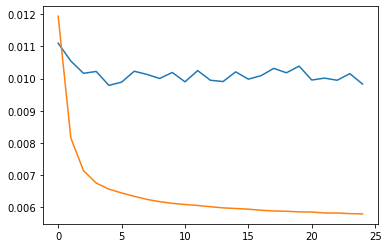

In [116]:
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])

In [117]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

In [118]:
print(log_max_inv(preds, max_log_y)[0])
print(log_max_inv(y_valid, max_log_y)[0])
print(math.sqrt(np.square(((log_max_inv(preds, max_log_y)[0] - log_max_inv(y_valid, max_log_y)[0])/log_max_inv(y_valid, max_log_y)[0]).mean())))

6568.476
7955.999999999996
0.1743996890122231


In [119]:
preds_log_max_inv = log_max_inv(preds, max_log_y)
print(preds_log_max_inv)

[ 6568.476   8758.239   4729.9683  7416.6646  5806.5415  4910.66
  5984.117   7140.2817  5094.0215  6452.6636  9326.851   7396.8228
  6763.8555  4783.734   6866.139   4942.472   8009.398   5015.486
  3560.537   6323.858  ...  5826.861  19023.127   4707.4766  5457.5195
 10039.38   26654.287   3675.856   3397.5205  3940.5427  9337.708
  3838.0398  3708.1396  2352.7239 10823.34    5761.69    3915.8103
 10401.271   5366.175   5349.4204  6830.102 ]


In [121]:
#Idem test
preds_test_log_max_inv = log_max_inv(preds_test, max_log_y)
print(preds_test_log_max_inv)

[ 3998.2937  7287.398   8564.776   7228.212   7654.6055  5507.693
  6988.3335  7952.6562  4850.594   5763.4595  6796.7163  7950.4873
  7230.232   9048.3545  5839.0767  4675.2056  5657.285  10058.748
 10723.903   9662.266  ...  7369.9463 14676.54    6596.996   5869.846
  7901.5894  8992.146   3523.8076  8963.404   7332.3203  5730.2905
  6735.3594  5196.994   3222.0962  5457.9414  4278.577   3001.5486
  8522.164   6200.7275 25600.88    7838.304 ]


In [ ]:
y_valid_array =  log_max_inv(np.array(y_valid), max_log_y)
print(y_valid_array)

In [ ]:
print(np.sqrt(np.mean(np.square((preds_log_max_inv - y_valid_array)/y_valid_array))))

In [115]:
y_pred_test = model.predict(map_test, verbose=1)[:,0]*y_max

1284/1284 [==============================] - 6s 5ms/step


NameError: name 'y_max' is not defined

In [127]:
import os
cwd = os.getcwd()

In [128]:
cwd

'C:\\Users\\Patricio\\deep-learning\\Machine-Learning\\Laboratorio-Metodos de ensamble\\dataset\\rossmann'

In [130]:
sample_csv = pd.read_csv('sample_submission.csv')
sample_csv['Sales'] = preds_test_log_max_inv
sample_csv.head()

sample_csv.to_csv('rossmann_NN_video.csv', index=False)

# XGBoost

In [172]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [173]:
n_estimators=4000
learning_rate=0.25
model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                     objective='reg:squarederror', n_jobs=12, max_depth=8, gamma=0.005)
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=0.005,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.25, max_delta_step=None, max_depth=8,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4000, n_jobs=12, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [176]:
fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_valid, y_valid)],
            'verbose': 100,
           }

In [177]:
model.fit(X_train, y_train, **fit_params)

[0]	validation_0-rmse:0.24067
[100]	validation_0-rmse:0.01680
[200]	validation_0-rmse:0.01570
[276]	validation_0-rmse:0.01570


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [178]:
y_pred_test = np.exp(model.predict(X_test)*max_log_y)

In [181]:
sample_csv = pd.read_csv('sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv('rossmann_XGBoost.csv', index=False)